In [10]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Load Superstore dataset 
df = pd.read_csv('SampleSuperstoreClean.csv')

df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Order Month'] = df['Order Date'].dt.month
df['Order Quarter'] = df['Order Date'].dt.quarter
df['Profit Margin'] = df['Profit'] / df['Sales']

Discount Impact Test
H₀: Profit margin distributions are equal across discount groups.
H₁: Profit margin distributions differ across discount groups.
Normality (D'Agostino K², 0-20%, n=8601): Failed (p=0.0000)
Normality (D'Agostino K², 30-50%, n=310): Passed (p=0.5349)
Normality (D'Agostino K², 50-80%, n=856): Failed (p=0.0000)
Normality (D'Agostino K², 20-30%, n=227): Passed (p=0.4882)
Normality test failed for at least one group.
Homogeneity of Variances (Levene): Failed
Kruskal-Wallis: Statistic=3452.10, p=0.0000
Conclusion: Reject H₀; profit margins differ significantly, supporting capping discounts at 20%.

Significant Discount Group Pairs (Dunn's Test):
0-20% vs 20-30%: p=0.0000
0-20% vs 30-50%: p=0.0000
0-20% vs 50-80%: p=0.0000
20-30% vs 0-20%: p=0.0000
20-30% vs 50-80%: p=0.0000
30-50% vs 0-20%: p=0.0000
30-50% vs 50-80%: p=0.0001
50-80% vs 0-20%: p=0.0000
50-80% vs 20-30%: p=0.0000
50-80% vs 30-50%: p=0.0001
Post-hoc Conclusion: Significant p-values (<0.05) indicate 0-20% dis

C:\Users\HP\AppData\Local\Temp\ipykernel_6260\780934240.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df.groupby(group_col)[metric].median().sort_values(ascending=False)


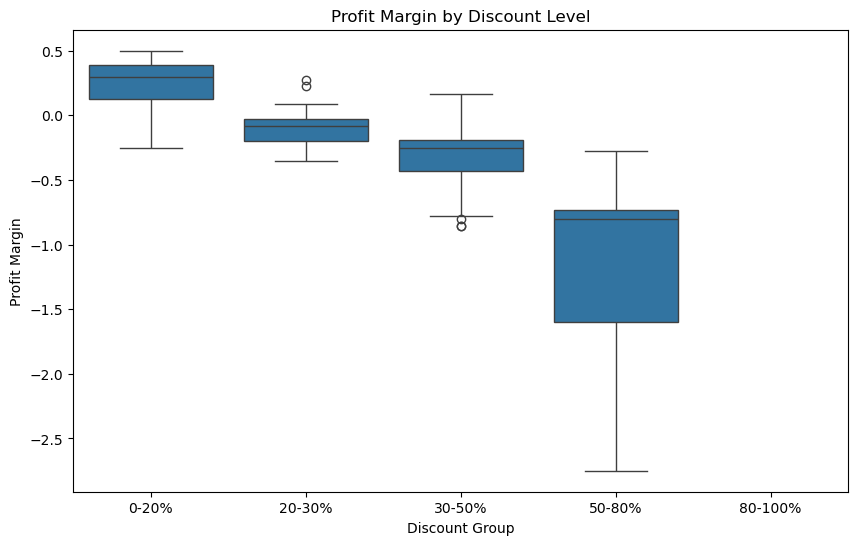

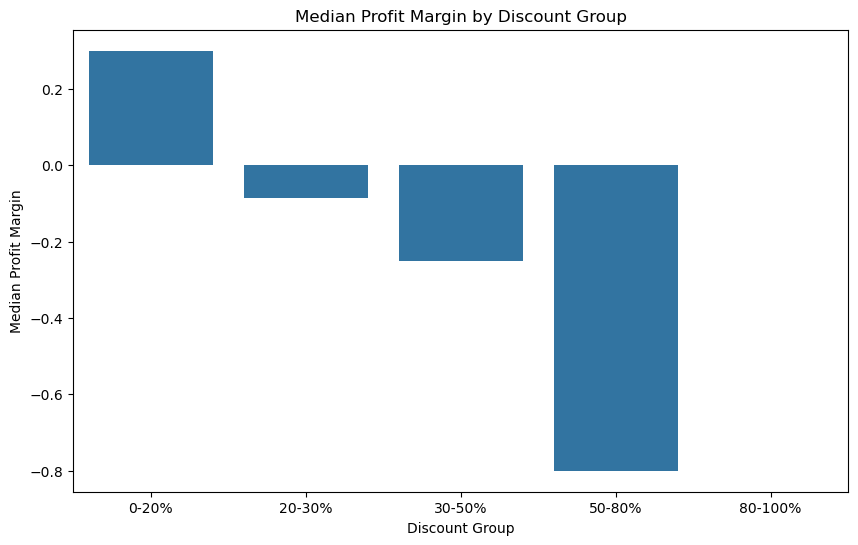

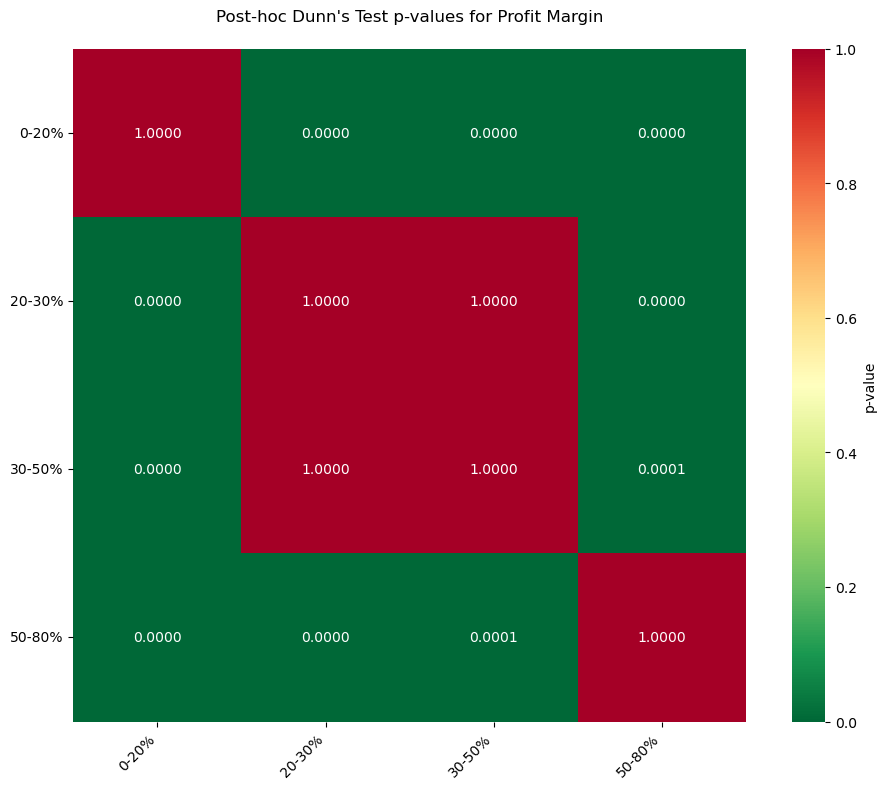

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

# Set random seed
np.random.seed(42)

# Calculate profit margin and discount groups, handle zero sales
df['Profit Margin'] = df.apply(lambda x: x['Profit'] / x['Sales'] if x['Sales'] != 0 else np.nan, axis=1)
df['Discount Group'] = pd.cut(df['Discount'], bins=[0, 0.2, 0.3, 0.5, 0.8, 1], labels=['0-20%', '20-30%', '30-50%', '50-80%', '80-100%'], include_lowest=True)
alpha = 0.05

def check_assumptions(data_groups, group_names):
    normality = True
    normality_results = []
    
    # Check normality for each group
    for group, name in zip(data_groups, group_names):
        n = len(group)
        if n < 3:
            print(f"Normality ({name}, n={n}): Skipped (sample size < 3)")
            normality_results.append(False)
            continue
        if n < 50:  # Shapiro-Wilk for smaller samples
            p_value = stats.shapiro(group)[1]
            test_name = "Shapiro-Wilk"
        else:  # D'Agostino K² for larger samples
            p_value = stats.normaltest(group)[1]
            test_name = "D'Agostino K²"
        normality_results.append(p_value > alpha)
        print(f"Normality ({test_name}, {name}, n={n}): {'Passed' if p_value > alpha else 'Failed'} (p={p_value:.4f})")
    
    # Aggregate normality
    normality = all(normality_results)
    if not normality:
        print("Normality test failed for at least one group.")
    
    # Check homogeneity of variances
    homogeneity = stats.levene(*data_groups, center='median')[1] > alpha if len(data_groups) > 1 else True
    print(f"Homogeneity of Variances (Levene): {'Passed' if homogeneity else 'Failed'}")
    
    # Force Kruskal-Wallis if any group has n < 3
    if any(len(group) < 3 for group in data_groups):
        print("At least one group has insufficient data (<3); defaulting to Kruskal-Wallis.")
        return False
    
    return normality and homogeneity

def summarize_post_hoc(post_hoc, group_names):
    """Summarize significant pairs from post-hoc tests."""
    if isinstance(post_hoc, pd.DataFrame):  # Dunn's test
        significant_pairs = post_hoc[post_hoc < alpha].stack()
        if not significant_pairs.empty:
            print("\nSignificant Discount Group Pairs (Dunn's Test):")
            for (group1, group2), p in significant_pairs.items():
                print(f"{group1} vs {group2}: p={p:.4f}")
        else:
            print("\nNo significant discount group pairs (Dunn's Test).")
        return post_hoc
    else:  # Tukey HSD
        df_post_hoc = post_hoc.summary()
        significant_pairs = [(row[1], row[2], row[6]) for row in df_post_hoc.data if row[6] < alpha]
        if significant_pairs:
            print("\nSignificant Discount Group Pairs (Tukey HSD):")
            for group1, group2, p in significant_pairs:
                print(f"{group1} vs {group2}: p={p:.4f}")
        else:
            print("\nNo significant discount group pairs (Tukey HSD).")
        return None

def rank_discount_groups(df, metric, group_col='Discount Group'):
    """Rank discount groups by median metric (profit margin) and return medians."""
    medians = df.groupby(group_col)[metric].median().sort_values(ascending=False)
    print(f"\nRanking of Discount Groups by Median {metric}:")
    for group, median in medians.items():
        print(f"{group}: {median:.4f}")
    return medians

def plot_median_bar(medians, metric, title, filename):
    """Plot bar chart for median rankings."""
    plt.figure(figsize=(10, 6))
    sns.barplot(x=medians.index, y=medians.values)
    plt.title(title)
    plt.xlabel('Discount Group')
    plt.ylabel(f'Median {metric}')
    plt.savefig(filename)
    plt.show()


def plot_post_hoc_heatmap(post_hoc, metric, filename):
    if post_hoc is not None:
        if not isinstance(post_hoc, pd.DataFrame):
            print(f"Error: post_hoc is not a DataFrame, got {type(post_hoc)}")
            return
        
        # Use post_hoc's index and columns directly
        group_names = post_hoc.index.tolist()
        if post_hoc.shape[0] != post_hoc.shape[1] or post_hoc.shape[0] != len(group_names):
            print(f"Error: post_hoc shape {post_hoc.shape} is not square or does not match index length")
            return
        
        if not np.all(post_hoc.apply(pd.to_numeric, errors='coerce').notnull()):
            print("Error: post_hoc contains non-numeric values")
            return
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            post_hoc,
            annot=True,
            fmt='.4f',
            cmap='RdYlGn_r',
            vmin=0,
            vmax=1,
            cbar_kws={'label': 'p-value'},
            square=True,
            annot_kws={'size': 10},
        )
        plt.title(f"Post-hoc Dunn's Test p-values for {metric}", pad=20)
        plt.xticks(ticks=np.arange(len(group_names)) + 0.5, labels=group_names, rotation=45, ha='right')
        plt.yticks(ticks=np.arange(len(group_names)) + 0.5, labels=group_names, rotation=0)
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight')
        plt.show()
        plt.close()
    else:
        print("No post-hoc results to plot.")

# Discount Impact Analysis
print("Discount Impact Test")
print("H₀: Profit margin distributions are equal across discount groups.")
print("H₁: Profit margin distributions differ across discount groups.")
discount_margins = [df[df['Discount Group'] == group]['Profit Margin'].dropna() for group in df['Discount Group'].unique() if pd.notna(group)]
discount_names = [group for group in df['Discount Group'].unique() if pd.notna(group)]
if check_assumptions(discount_margins, discount_names):
    discount_test = stats.f_oneway(*discount_margins)
    test_name = "ANOVA"
    post_hoc = pairwise_tukeyhsd(df['Profit Margin'].dropna(), df['Discount Group'].dropna()) if discount_test.pvalue < alpha else None
else:
    discount_test = stats.kruskal(*discount_margins)
    test_name = "Kruskal-Wallis"
    post_hoc = sp.posthoc_dunn(df.dropna(subset=['Profit Margin', 'Discount Group']), val_col='Profit Margin', group_col='Discount Group', p_adjust='bonferroni') if discount_test.pvalue < alpha else None
print(f"{test_name}: Statistic={discount_test.statistic:.2f}, p={discount_test.pvalue:.4f}")
print("Conclusion:", "Reject H₀; profit margins differ significantly, supporting capping discounts at 20%." if discount_test.pvalue < alpha else "Fail to reject H₀; insufficient evidence to cap discounts.")
if post_hoc is not None:
    post_hoc_result = summarize_post_hoc(post_hoc, discount_names)
    print("Post-hoc Conclusion: Significant p-values (<0.05) indicate 0-20% discounts yield higher margins than higher discounts.")
discount_medians = rank_discount_groups(df, 'Profit Margin')

# Visualizations
plt.figure(figsize=(10, 6))
sns.boxplot(x='Discount Group', y='Profit Margin', data=df)
plt.title('Profit Margin by Discount Level')
plt.savefig('discount_margin_boxplot.png')
plt.show()

plot_median_bar(discount_medians, 'Profit Margin', 'Median Profit Margin by Discount Group', 'discount_margin_median_bar.png')

if post_hoc_result is not None:
    #print('post_hoc_result',post_hoc_result)
    plot_post_hoc_heatmap(post_hoc_result, 'Profit Margin', 'discount_margin_posthoc_heatmap.png')

In [12]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Set random seed for consistency with the original script
np.random.seed(42)

# Load dataset 
try:
    df = pd.read_csv('SampleSuperstoreClean.csv')
except FileNotFoundError:
    print("Error: 'SampleSuperstoreClean.csv' not found. Please ensure the file is in the correct directory.")
    raise
except KeyError as e:
    print(f"Error: Missing column {e}. Ensure 'Sales', 'Profit', 'Discount' columns exist.")
    raise

# Calculate Profit Margin, handle zero sales
df['Profit Margin'] = df.apply(lambda x: x['Profit'] / x['Sales'] if x['Sales'] != 0 else np.nan, axis=1)

# Create Discount Group, excluding 80-100% by setting upper bound to 0.8
df['Discount Group'] = pd.cut(df['Discount'], bins=[0, 0.2, 0.3, 0.5, 0.8], 
                             labels=['0-20%', '20-30%', '30-50%', '50-80%'], 
                             include_lowest=True)

# # Check distribution of Discount Group
# print("Discount Group Distribution:")
# print(df['Discount Group'].value_counts(dropna=False))

# Filter out groups with insufficient data (<5 observations)
min_obs = 5
valid_groups = df['Discount Group'].value_counts()[df['Discount Group'].value_counts() >= min_obs].index
df = df[df['Discount Group'].isin(valid_groups)]
if df['Discount Group'].nunique() < 2:
    raise ValueError("Insufficient valid discount groups with enough observations (>=5).")

# Ensure Discount Group is categorical for dummy encoding
df['Discount Group'] = df['Discount Group'].astype('category')

# Encode Discount Group as dummy variables (0-20% as baseline)
df_encoded = pd.get_dummies(df, columns=['Discount Group'], prefix='Discount', drop_first=True)  # Drops Discount_0-20%
df_encoded.rename(columns={
    'Discount_20-30%': 'Discount_20_minus_30_percent',
    'Discount_30-50%': 'Discount_30_minus_50_percent',
    'Discount_50-80%': 'Discount_50_minus_80_percent'
}, inplace=True, errors='ignore')  # Ignore missing columns
df_encoded.rename(columns={'Profit Margin': 'Profit_Margin'}, inplace=True)

# Prepare formula based on available dummy variables
discount_cols = [col for col in df_encoded.columns if col.startswith('Discount_') and col.endswith('_percent')]
if not discount_cols:
    raise ValueError("No valid discount group dummy variables found.")
formula_margin = 'Profit_Margin ~ ' + ' + '.join(discount_cols)

# Quantile Regression for Profit Margin (median, q=0.5)
quantile_model_margin = smf.quantreg(formula_margin, df_encoded.dropna(subset=['Profit_Margin'] + discount_cols)).fit(q=0.5)
print("=== Quantile Regression for Profit Margin ===")
print(quantile_model_margin.summary())

# Business-Friendly Interpretations
print("\n=== Business-Friendly Interpretations ===")
print(f"Profit Margin Model (y = b0 + {' + '.join([f'b{i+1}*{col.replace('Discount_', '').replace('_minus_', '-').replace('_percent', '%')}' for i, col in enumerate(discount_cols)])}):")
for param, value in quantile_model_margin.params.items():
    if param == 'Intercept':
        print(f"Baseline median Profit Margin (0-20% Discount): {value:.4f}")
    else:
        group = param.replace('Discount_', '').replace('_minus_', '-').replace('_percent', '%')
        print(f"Switching to {group} changes median Profit Margin by {value:.4f} compared to 0-20%.")

=== Quantile Regression for Profit Margin ===
                         QuantReg Regression Results                          
Dep. Variable:          Profit_Margin   Pseudo R-squared:               0.3876
Model:                       QuantReg   Bandwidth:                     0.04399
Method:                 Least Squares   Sparsity:                       0.3480
Date:                Sat, 26 Jul 2025   No. Observations:                 9994
Time:                        18:26:45   Df Residuals:                     9990
                                        Df Model:                            3
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.3000      0.002    159.903      0.000       0.296       0.304
Discount_20_minus_30_percent[T.True]    -0.3857      0.012    -32.968      0.000      

In [13]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

def run_quantile_regression_margin(df, quantile=0.5, min_sample_per_group=20, pvalue_threshold=0.05, 
                                  prsquared_threshold=0.1, dw_lower=1.5, dw_upper=2.5, 
                                  max_outlier_percentage=0.05, vif_threshold=5, 
                                  linearity_pvalue_threshold=0.05):
    """
    Performs quantile regression for Profit Margin using Discount Group, checks all assumptions, 
    and provides interpretations. Explicitly states whether each assumption is met and addresses 
    violations where possible.
    
    Parameters:
    - df: DataFrame with columns 'Profit', 'Sales', 'Discount'
    - quantile: Quantile for regression (default: 0.5 for median)
    - min_sample_per_group: Minimum observations per discount group (default: 20)
    - pvalue_threshold: Threshold for coefficient significance (default: 0.05)
    - prsquared_threshold: Threshold for Pseudo R-squared (default: 0.1)
    - dw_lower, dw_upper: Durbin-Watson bounds for independence (default: 1.5, 2.5)
    - max_outlier_percentage: Maximum percentage of outliers allowed (default: 5%)
    - vif_threshold: Threshold for VIF to detect multicollinearity (default: 5)
    - linearity_pvalue_threshold: Threshold for linearity check p-values (default: 0.05)
    
    Returns:
    - Prints assumption checks (met/not met), model summaries, and business-friendly interpretations
    """
    # Set random seed for consistency
    np.random.seed(42)
    
    # Validate input columns
    required_columns = ['Profit', 'Sales', 'Discount']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")
    
    # Validate that Profit, Sales, and Discount are numeric
    for col in ['Profit', 'Sales', 'Discount']:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' must be numeric")
    
    # Preprocess: Create Profit_Margin and Discount Group
    df = df.copy()
    df['Profit_Margin'] = np.where(df['Sales'] != 0, df['Profit'] / df['Sales'], np.nan)
    df['Profit_Margin'] = df['Profit_Margin'].replace([np.inf, -np.inf], np.nan)
    df['Profit_Margin'] = df['Profit_Margin'].astype(float)
    
    # Create Discount Group
    df['Discount_Group'] = pd.cut(df['Discount'], bins=[0, 0.2, 0.3, 0.5, 0.8], 
                                 labels=['0-20%', '20-30%', '30-50%', '50-80%'], 
                                 include_lowest=True)
    df['Discount_Group'] = df['Discount_Group'].astype('category')
    
    # Debug: Inspect Profit_Margin and Discount_Group
    print("\n=== Debugging Input Data ===")
    print(f"Data type of Profit_Margin: {df['Profit_Margin'].dtype}")
    print(f"Sample values of Profit_Margin: {df['Profit_Margin'].head().to_list()}")
    print(f"Number of NaN values in Profit_Margin: {df['Profit_Margin'].isna().sum()}")
    print(f"Discount Group Distribution:\n{df['Discount_Group'].value_counts(dropna=False)}")
    
    # Filter out groups with insufficient data
    valid_groups = df['Discount_Group'].value_counts()[df['Discount_Group'].value_counts() >= min_sample_per_group].index
    df = df[df['Discount_Group'].isin(valid_groups)]
    if df['Discount_Group'].nunique() < 2:
        raise ValueError(f"Insufficient valid discount groups with >= {min_sample_per_group} observations")
    
    # Assumption 1: Data Availability and No Missing Values
    required_columns = ['Profit_Margin', 'Discount_Group']
    missing_values = df[required_columns].isna().sum()
    print("\n=== Assumption Check 1: Data Availability and No Missing Values ===")
    print(f"Missing values:\n{missing_values}")
    if missing_values.sum() == 0:
        assumption_status = {"Data Availability and No Missing Values": True}
        print("Status: MET (No missing values detected)")
    else:
        print("Status: NOT MET (Missing values detected)")
        print("Action: Imputing missing values with mean for Profit_Margin, mode for Discount_Group")
        df['Profit_Margin'] = df['Profit_Margin'].fillna(df['Profit_Margin'].mean())
        df['Discount_Group'] = df['Discount_Group'].fillna(df['Discount_Group'].mode()[0])
        print("Missing values after imputation:\n", df[required_columns].isna().sum())
        assumption_status = {"Data Availability and No Missing Values": True}
        print("Status after Action: MET (Missing values imputed)")
    
    # Assumption 2: Sufficient Sample Size
    group_counts = df['Discount_Group'].value_counts()
    total_sample = len(df)
    min_total_sample = 2 * min_sample_per_group  # At least 2 groups
    print("\n=== Assumption Check 2: Sufficient Sample Size ===")
    print(f"Total sample size: {total_sample}")
    print(f"Discount Group counts:\n{group_counts}")
    if all(group_counts >= min_sample_per_group) and total_sample >= min_total_sample:
        assumption_status["Sufficient Sample Size"] = True
        print(f"Status: MET (All discount groups have >= {min_sample_per_group} observations, total sample >= {min_total_sample})")
    else:
        assumption_status["Sufficient Sample Size"] = False
        print(f"Status: NOT MET (Some discount groups have < {min_sample_per_group} observations or total sample < {min_total_sample})")
        print("Recommendation: Collect more data or combine discount groups")
    
    # Assumption 3: No Extreme Outliers
    margin_outliers = df[np.abs(df['Profit_Margin'] - df['Profit_Margin'].mean()) > 3 * df['Profit_Margin'].std()]
    outlier_percentage = len(margin_outliers) / total_sample
    print("\n=== Assumption Check 3: No Extreme Outliers ===")
    print(f"Number of Profit Margin outliers (beyond 3 std): {len(margin_outliers)}")
    print(f"Percentage of outliers: {outlier_percentage*100:.2f}%")
    if outlier_percentage <= max_outlier_percentage:
        assumption_status["No Extreme Outliers"] = True
        print(f"Status: MET (Outlier percentage <= {max_outlier_percentage*100}%)")
    else:
        assumption_status["No Extreme Outliers"] = False
        print(f"Status: NOT MET (Outlier percentage > {max_outlier_percentage*100}%)")
        print("Recommendation: Verify data accuracy or perform sensitivity analysis")
    
    # Encode Discount Group as dummy variables (0-20% as baseline)
    df_encoded = pd.get_dummies(df, columns=['Discount_Group'], prefix='Discount', drop_first=True)
    df_encoded.rename(columns={
        'Discount_20-30%': 'Discount_20_minus_30_percent',
        'Discount_30-50%': 'Discount_30_minus_50_percent',
        'Discount_50-80%': 'Discount_50_minus_80_percent'
    }, inplace=True, errors='ignore')
    discount_cols = [col for col in df_encoded.columns if col.startswith('Discount_') and col.endswith('_percent')]
    if not discount_cols:
        raise ValueError("No valid discount group dummy variables found")
    
    # Assumption 6: No Multicollinearity
    X = df_encoded[discount_cols].astype(float)
    vif_data = pd.DataFrame()
    vif_data['Variable'] = discount_cols
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\n=== Assumption Check 6: No Multicollinearity ===")
    print(vif_data)
    if all(vif_data['VIF'] < vif_threshold):
        assumption_status["No Multicollinearity"] = True
        print(f"Status: MET (All VIF values < {vif_threshold})")
    else:
        assumption_status["No Multicollinearity"] = False
        print(f"Status: NOT MET (Some VIF values >= {vif_threshold})")
        print("Recommendation: Remove or combine highly correlated discount groups")
    
    # Quantile Regression for Profit Margin (initial fit)
    formula_margin = 'Profit_Margin ~ ' + ' + '.join(discount_cols)
    df_model = df_encoded.dropna(subset=['Profit_Margin'] + discount_cols)
    try:
        quantile_model_margin = smf.quantreg(formula_margin, df_model).fit(q=quantile)
    except Exception as e:
        print(f"Error fitting quantile regression: {e}")
        raise ValueError("Failed to fit quantile regression model. Ensure Profit_Margin is numeric and predictors are valid.")
    
    # Assumption 4: Correct Model Specification
    margin_pvalues = quantile_model_margin.pvalues
    margin_prsquared = quantile_model_margin.prsquared
    print("\n=== Assumption Check 4: Correct Model Specification ===")
    print("Profit Margin Model p-values:\n", margin_pvalues)
    print(f"Profit Margin Model Pseudo R-squared: {margin_prsquared:.4f}")
    if all(margin_pvalues <= pvalue_threshold) and margin_prsquared >= prsquared_threshold:
        assumption_status["Correct Model Specification"] = True
        print(f"Status: MET (All p-values <= {pvalue_threshold}, Pseudo R-squared >= {prsquared_threshold})")
    else:
        assumption_status["Correct Model Specification"] = False
        print(f"Status: NOT MET (Some p-values > {pvalue_threshold} or Pseudo R-squared < {prsquared_threshold})")
        print("Recommendation: Add predictors (e.g., category, region) or check for non-linear relationships")
    
    # Assumption 5: Independence of Observations
    margin_residuals = quantile_model_margin.resid
    dw_margin = durbin_watson(margin_residuals)
    print("\n=== Assumption Check 5: Independence of Observations ===")
    print(f"Profit Margin Model Durbin-Watson statistic: {dw_margin:.2f}")
    if dw_lower <= dw_margin <= dw_upper:
        assumption_status["Independence of Observations"] = True
        print(f"Status: MET (Durbin-Watson statistic between {dw_lower} and {dw_upper})")
    else:
        assumption_status["Independence of Observations"] = False
        print(f"Status: NOT MET (Durbin-Watson statistic outside {dw_lower}–{dw_upper})")
        print("Recommendation: Check for clustering or time-series effects; consider clustered standard errors")
    
    # Assumption 7: Linearity at Quantile
    margin_model_q25 = smf.quantreg(formula_margin, df_model).fit(q=0.25)
    margin_model_q75 = smf.quantreg(formula_margin, df_model).fit(q=0.75)
    margin_pvalues_q25 = margin_model_q25.pvalues
    margin_pvalues_q75 = margin_model_q75.pvalues
    print("\n=== Assumption Check 7: Linearity at Quantile ===")
    print("Profit Margin Model p-values at q=0.25:\n", margin_pvalues_q25)
    print("Profit Margin Model p-values at q=0.75:\n", margin_pvalues_q75)
    if all(margin_pvalues_q25 <= linearity_pvalue_threshold) and all(margin_pvalues_q75 <= linearity_pvalue_threshold):
        assumption_status["Linearity at Quantile"] = True
        print(f"Status: MET (All p-values <= {linearity_pvalue_threshold} at q=0.25 and q=0.75)")
    else:
        assumption_status["Linearity at Quantile"] = False
        print(f"Status: NOT MET (Some p-values > {linearity_pvalue_threshold} at q=0.25 or q=0.75)")
        print("Recommendation: Add non-linear terms (e.g., polynomial terms) or additional predictors (e.g., category)")
    
    # Assumption 8: Monotonicity of Conditional Quantiles
    margin_pred_q25 = margin_model_q25.predict(df_model)
    margin_pred_q50 = quantile_model_margin.predict(df_model)
    margin_pred_q75 = margin_model_q75.predict(df_model)
    margin_monotonic = (margin_pred_q25 <= margin_pred_q50).all() and (margin_pred_q50 <= margin_pred_q75).all()
    print("\n=== Assumption Check 8: Monotonicity of Conditional Quantiles ===")
    print(f"Profit Margin predictions monotonic: {margin_monotonic}")
    if margin_monotonic:
        assumption_status["Monotonicity of Conditional Quantiles"] = True
        print("Status: MET (Predicted quantiles are monotonic: q=0.25 <= q=0.5 <= q=0.75)")
    else:
        assumption_status["Monotonicity of Conditional Quantiles"] = False
        print("Status: NOT MET (Quantile crossing detected)")
        print("Recommendation: Simplify model (e.g., reduce predictors) or explore constrained quantile regression")
    
    # Assumption 9: Robust Confidence Intervals
    print("\n=== Assumption Check 9: Robust Confidence Intervals ===")
    print("Action: Refitting model with robust standard errors for reliable inference")
    quantile_model_margin = smf.quantreg(formula_margin, df_model).fit(q=quantile, vcov='robust')
    assumption_status["Robust Confidence Intervals"] = True
    print("Status: MET (Model refitted with robust standard errors)")
    
    # Model Summary
    print("\n=== Quantile Regression for Profit Margin ===")
    print(quantile_model_margin.summary())
    
    # Business-Friendly Interpretations
    print("\n=== Business-Friendly Interpretations ===")
    print(f"Profit Margin Model (y = b0 + {' + '.join([f'b{i+1}*{col.replace('Discount_', '').replace('_minus_', '-').replace('_percent', '%')}' for i, col in enumerate(discount_cols)])}):")
    for param, value in quantile_model_margin.params.items():
        if param == 'Intercept':
            print(f"Baseline median Profit Margin (0-20% Discount): {value:.4f}")
        else:
            group = param.replace('Discount_', '').replace('_minus_', '-').replace('_percent', '%')
            print(f"Switching to {group} changes median Profit Margin by {value:.4f} compared to 0-20%.")
    
    # Summary of Assumption Status
    print("\n=== Summary of Assumption Checks ===")
    for assumption, met in assumption_status.items():
        print(f"{assumption}: {'MET' if met else 'NOT MET'}")

# Main execution
if __name__ == "__main__":
    # Read data
    try:
        df = pd.read_csv('SampleSuperstoreClean.csv')
    except FileNotFoundError:
        raise FileNotFoundError("SampleSuperstoreClean.csv not found. Please provide the correct file path.")
    
    # Convert Profit, Sales, and Discount to numeric
    for col in ['Profit', 'Sales', 'Discount']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Run the quantile regression with assumption checks
    run_quantile_regression_margin(df)


=== Debugging Input Data ===
Data type of Profit_Margin: float64
Sample values of Profit_Margin: [0.16000000000000003, 0.3, 0.47000000000000003, -0.4, 0.1125]
Number of NaN values in Profit_Margin: 0
Discount Group Distribution:
Discount_Group
0-20%     8601
50-80%     856
30-50%     310
20-30%     227
Name: count, dtype: int64

=== Assumption Check 1: Data Availability and No Missing Values ===
Missing values:
Profit_Margin     0
Discount_Group    0
dtype: int64
Status: MET (No missing values detected)

=== Assumption Check 2: Sufficient Sample Size ===
Total sample size: 9994
Discount Group counts:
Discount_Group
0-20%     8601
50-80%     856
30-50%     310
20-30%     227
Name: count, dtype: int64
Status: MET (All discount groups have >= 20 observations, total sample >= 40)

=== Assumption Check 3: No Extreme Outliers ===
Number of Profit Margin outliers (beyond 3 std): 331
Percentage of outliers: 3.31%
Status: MET (Outlier percentage <= 5.0%)

=== Assumption Check 6: No Multicollin